Sources of information for various additions:
-RMS sensitivty loss regularisation term: Sensitivity Analysis of Deep Neural Networks, Hai Shu and Hongtu Zhu. AAAI19 conference.

Libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

Device Selection

In [15]:
if torch.cuda.is_available():
    my_device = torch.device("cuda")
else:
    my_device = torch.device("cpu")

Data

In [16]:
def target_function(x):
    x = np.array(x,dtype=np.float32)
    y1 = np.array(12*x**4 + 81*x**2 - 10*x + 14)
    y2 = np.array(48*x**3 + 162*x - 10)
    return y1,y2

train_data_raw = range(-1000, 1000)
y1_raw, y2_raw = target_function(train_data_raw)

inputs = torch.tensor(list(train_data_raw), dtype=torch.float32).unsqueeze(1)
targets = torch.tensor(np.stack([y1_raw, y2_raw], axis=1), dtype=torch.float32)

Hyperparameters

In [17]:
Learn_Rate = 0.01
beta1 = 0.9
beta2 = 0.999
num_epochs = 100
alpha = 1.0 # weight of energy derivative loss comparative to energy loss

Model Architecture 

In [18]:
strain_dims = 1
Layer1_output_dim = 1024
Layer2_output_dim = 512
Layer3_output_dim = 128
Energy_dims = 1
Energy_derivative_dims = 1

class unit_approximation(nn.Module):

    def __init__(self, input_dims, output1_dims, output2_dims):
        super().__init__()

        self.Layer1 = nn.Linear(input_dims, Layer1_output_dim)
        self.Layer2 = nn.Linear(Layer1_output_dim, Layer2_output_dim)
        self.Layer3 = nn.Linear(Layer2_output_dim, Layer3_output_dim)
        self.energy_head = nn.Linear(Layer3_output_dim, output1_dims)
        self.energy_derivative_head = nn.Linear(Layer3_output_dim, output2_dims)

        self.relu = nn.ReLU() # Note: looking to create an activation function that would allow discontinuities
        
    def forward(self, X):
        X = self.Layer1(X)
        X = self.relu(X)
        X = self.Layer2(X)
        X = self.relu(X)
        X = self.Layer3(X)
        X = self.relu(X)
        X1 = self.energy_head(X)
        X2 = self.energy_derivative_head(X)

        return X1,X2

# Instantiate Model
Model = unit_approximation(strain_dims, Energy_dims, Energy_derivative_dims)

Optimiser and Loss

In [19]:
optimiser = optim.Adam(Model.parameters(),lr=Learn_Rate,betas=(beta1,beta2))

Loss = torch.nn.MSELoss()
# Quantile Loss function can handle discontinuities but using mean square error here for ease of computation, also lloking at custom loss functions

Training Loop

In [20]:
loss_record = []
batch_size = 5
batches_per_epoch = len(inputs) // batch_size

for epoch in range(num_epochs):

    running_loss = 0

    for i in tqdm(range(batches_per_epoch),desc=f"Epoch {epoch}/{num_epochs}", leave=False):

        start = i * batch_size

        inputs_batch = inputs[start:start+batch_size]
        targets_batch = targets[start:start+batch_size]

        inputs_batch.to(device=my_device)
        targets_batch.to(device=my_device)

        optimiser.zero_grad()

        energy_pred, deriv_pred = Model(inputs_batch)

        energy_target = targets_batch[:, 0].unsqueeze(1)
        deriv_target = targets_batch[:, 1].unsqueeze(1)

        loss_energy = Loss(energy_pred, energy_target)
        loss_derivative = Loss(deriv_pred, deriv_target)

        loss = loss_energy + alpha * loss_derivative

        loss.backward()
        optimiser.step()

        if torch.isnan(loss):
            print(f"Loss became NaN at batch {i+1} in epoch {epoch+1}!")
            if torch.isnan(Model.Layer1.weight).any():
                print("Model weights have been corrupted by NaN values.")
            break

        running_loss += loss.item()

    loss_record.append(running_loss)

    
        

RMS sensitivty

Plot Loss

[6.118152078777008e+27, 5.949845890754029e+27, 5.722533196289207e+27, 5.478537096694955e+27, 5.241124510552014e+27, 5.069307343367083e+27, 4.918207446119155e+27, 4.7775925676806596e+27, 4.6449292945185955e+27, 4.5189910018291005e+27, 4.399052612280568e+27, 4.2846396992306445e+27, 4.1754187810051473e+27, 4.089096032984388e+27, 3.9909519603322335e+27, 3.897075383991974e+27, 3.8077021351892577e+27, 3.7225932703894385e+27, 3.641643694779577e+27, 3.564708694699643e+27, 3.491660683429953e+27, 3.4223707089089517e+27, 3.356707955113165e+27, 3.294539187225692e+27, 3.235728968903358e+27, 3.180143697199961e+27, 3.127647209875807e+27, 3.078104917407581e+27, 3.0313827235107054e+27, 2.9873485873461443e+27, 2.9458724447669454e+27, 2.906826817590247e+27, 2.8700869609578745e+27, 2.835531467414007e+27, 2.803042926486901e+27, 2.7725076771108164e+27, 2.743817210785533e+27, 2.7168659839913917e+27, 2.691554386599631e+27, 2.66778629270851e+27, 2.645470093604965e+27, 2.624519615834651e+27, 2.604852847901472e+

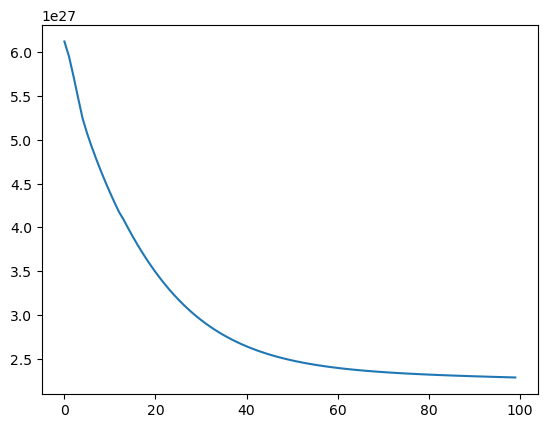

In [21]:
plt.plot(range(num_epochs),loss_record)

print(loss_record)

Predict Outputs

In [22]:
x = [55.5,62.1]
xT = torch.tensor(list(x), dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    y_pred, y_deriv_pred = Model(xT)

y_acc, y_deriv_acc = target_function(x)

print(y_acc)
print(y_deriv_acc)

print(y_acc)
print(y_deriv_acc)

[1.1410425e+08 1.7877453e+08]
[8.2147670e+06 1.1505236e+07]
[1.1410425e+08 1.7877453e+08]
[8.2147670e+06 1.1505236e+07]
